In [49]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, re
import time
random.seed(time.clock())

/Users/jinli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
#read tsp data file

def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX,coordY])
        cities = pd.DataFrame(cities_coord)
        return dimension, cities

In [51]:
#Create two classes: City and Fitness
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [52]:
#Running the genetic algorithm
#First, we need to get the cities
filename='/Users/jinli/dj38.tsp'
nb_cities, cities_coord = read_tsplib_file(filename)
print(cities_coord)


             0           1
0   11003.6111  42102.5000
1   11108.6111  42373.8889
2   11133.3333  42885.8333
3   11155.8333  42712.5000
4   11183.3333  42933.3333
5   11297.5000  42853.3333
6   11310.2778  42929.4444
7   11416.6667  42983.3333
8   11423.8889  43000.2778
9   11438.3333  42057.2222
10  11461.1111  43252.7778
11  11485.5556  43187.2222
12  11503.0556  42855.2778
13  11511.3889  42106.3889
14  11522.2222  42841.9444
15  11569.4444  43136.6667
16  11583.3333  43150.0000
17  11595.0000  43148.0556
18  11600.0000  43150.0000
19  11690.5556  42686.6667
20  11715.8333  41836.1111
21  11751.1111  42814.4444
22  11770.2778  42651.9444
23  11785.2778  42884.4444
24  11822.7778  42673.6111
25  11846.9444  42660.5556
26  11963.0556  43290.5556
27  11973.0556  43026.1111
28  12058.3333  42195.5556
29  12149.4444  42477.5000
30  12286.9444  43355.5556
31  12300.0000  42433.3333
32  12355.8333  43156.3889
33  12363.3333  43189.1667
34  12372.7778  42711.3889
35  12386.6667  43334.7222
3

In [53]:
city_list = []
for i in range(0,nb_cities):
    city_list.append(City(x=cities_coord.loc[i,0], y=cities_coord.loc[i,1]))
    
print(city_list)  
#type(cityList)

[(11003.6111,42102.5), (11108.6111,42373.8889), (11133.3333,42885.8333), (11155.8333,42712.5), (11183.3333,42933.3333), (11297.5,42853.3333), (11310.2778,42929.4444), (11416.6667,42983.3333), (11423.8889,43000.2778), (11438.3333,42057.2222), (11461.1111,43252.7778), (11485.5556,43187.2222), (11503.0556,42855.2778), (11511.3889,42106.3889), (11522.2222,42841.9444), (11569.4444,43136.6667), (11583.3333,43150.0), (11595.0,43148.0556), (11600.0,43150.0), (11690.5556,42686.6667), (11715.8333,41836.1111), (11751.1111,42814.4444), (11770.2778,42651.9444), (11785.2778,42884.4444), (11822.7778,42673.6111), (11846.9444,42660.5556), (11963.0556,43290.5556), (11973.0556,43026.1111), (12058.3333,42195.5556), (12149.4444,42477.5), (12286.9444,43355.5556), (12300.0,42433.3333), (12355.8333,43156.3889), (12363.3333,43189.1667), (12372.7778,42711.3889), (12386.6667,43334.7222), (12421.6667,42895.5556), (12645.0,42973.3333)]


### The preselection of population

In [54]:
def fitness(route):
    distance = 0
    for i in range(len(route)):
        distance += city_list[route[i-1]].distance(city_list[route[i]])
    return distance

random.seed(30)

def mutate(dad, rate):
    permute = []
    permute = [[np.random.randint(len(city_list)), np.random.randint(len(city_list))] for i in range(rate)]
    route = [dad[i] for i in range(len(dad))]
    for i in range(rate):
        temp = route[permute[i][0]]
        route[permute[i][0]] = route[permute[i][1]]
        route[permute[i][1]] = temp
    return route

def rotate(l, n):
    return l[-n:] + l[:-n]

#This crossover uses 3 parents, A and B provide the "genes", C is used to determine the shape
#The idea is, that you want to keep parts that are close together, and just find a more efficient way to connect the points in this part
def crossover(A,B,C):
    temp = rotate(C,np.random.randint(0,len(C)+1))
    C1 = temp[:int(len(C)/2)]
    C2 = temp[int(len(C)/2):]
    ret = []
    for a in A:
        if a in C1:
            ret.append(a)
    for b in B:
        if b in C2:
            ret.append(b)
    return ret

In [55]:
#Intersection of two lines defined by two pair of points (A,B) and (C,D). Used for the resolving of crossings
def intersect(A,B,C,D):
    if D[0] == C[0] and B[0] == A[0]:
        return False
    if B[0] == A[0]:
        M2 = (D[1] - C[1])*1.0/(D[0] - C[0])
        C2 = C[1]-(M2*C[0])
        X0 = B[0]
        return [X0, M2*X0 +C2]
    if D[0] == C[0]:
        M1 = (B[1] - A[1])*1.0/(B[0] - A[0])
        C1 = A[1]-(M1*A[0])
        X0 = B[0]
        return [X0, M1*X0 +C1]
    
    M1 = (B[1] - A[1])*1.0/(B[0] - A[0])
    M2 = (D[1] - C[1])*1.0/(D[0] - C[0])
    
    C1 = A[1]-(M1*A[0])
    C2 = C[1]-(M2*C[0])
    
    if M1 == M2:
        return False
    
    else:
        X0 = (C1 - C2)/(M2 - M1)
        return [X0, M2*X0 +C2]

#This function checks (in the most naive way) if the intersection will given an intersection in the graph    
def check_intersect(A,B,C,D):
    E = intersect(A,B,C,D)
    FX_Max = max(A[0],B[0])
    FX_Min = min(A[0],B[0])
    GX_Max = max(C[0],D[0])
    GX_Min = min(C[0],D[0])
    
    FY_Max = max(A[1],B[1])
    FY_Min = min(A[1],B[1])
    GY_Max = max(C[1],D[1])
    GY_Min = min(C[1],D[1])
    
    if E == False:
        return False
    if E[0] >= FX_Max:
        return False
    if E[0] <= FX_Min:
        return False
    if E[0] >= GX_Max:
        return False
    if E[0] <= GX_Min:
        return False
    
    if E[1] >= FY_Max:
        return False
    if E[1] <= FY_Min:
        return False
    if E[1] >= GY_Max:
        return False
    if E[1] <= GY_Min:
        return False
    else:
        return True

In [56]:
#Graph class, used for drawing the map and making the initial guess
class graph:
    def __init__(self, vertices, edges):
        self.edges = edges
        self.vertices = vertices
    def draw_map(self):
        plt.figure(figsize=(8,8))
        for e in self.edges:
            plt.plot([city_list[e[0]].x, city_list[e[1]].x], [city_list[e[0]].y, city_list[e[1]].y] , linestyle='-', color = 'turquoise')
        for v in self.vertices:
            plt.scatter(city_list[v].x,city_list[v].y, color='red')
            plt.text(city_list[v].x-20, city_list[v].y+40, str(v), fontsize=10)
        plt.axis('scaled')
        plt.show()
    #This function is used in the create_route methode down below
    def connected_components(self):
        comps = [{a} for a in self.vertices]
        for e in self.edges:
            inside = -1
            i = 0
            while i < len(comps):
                if inside >= 0:
                    if e[0] in comps[i] or e[1] in comps[i]:
                        comps[i].add(e[1])
                        comps[i].add(e[0])
                        for a in comps[i]:
                            comps[inside].add(a)
                        comps.pop(i)
                    else:
                        i+=1
                else:
                    if e[0] in comps[i] or e[1] in comps[i]:
                        comps[i].add(e[1])
                        inside = i
                    i += 1
        return comps
    
    def edges_at_v(self,vertex):
        ret = []
        for e in self.edges:
            if vertex == e[0]:
                ret.append(e[1])
            elif vertex == e[1]:
                ret.append(e[0])
        return ret
    
    
    def create_route(self):
        if self.connected_components() == 1:
            connected = True
        else:
            connected = False
        check = [i for i in range(1,len(city_list))]
        cur = 0
        skip = False
        route = [0]
        while check != []:
            skip = False
            temp = self.edges_at_v(cur)
            cand = [temp[i] for i in range(len(temp))]
            offset = 0
            for j in range(len(cand)):
                if cand[j - offset] not in check:
                    cand.pop(j - offset)
                    offset += 1
            #The results might be better if you choose an epsilon that gives a connected graph (the lowest so might be the best)
            #To avoid that you might want to change this function
            if cand == []:
                if connected:
                    skip = True
                    cand = [temp[i] for i in range(len(temp))]
                else:
                    cand = [np.random.choice(check)]
                    
            upcoming = random.choice(cand)
            cur = upcoming
            if skip == False:
                route.append(cur)
                check.pop(check.index(cur))
        return route

In [57]:
#This function resolves (more or less) the crossings in a path by "twisting" loops (imagine you want to turn "8" to "O" by twisting a String).
def resolve(ls, cut = 10):
    test2 = [ls[i] for i in range(len(ls))]
    y = 0
    z = 0
    while y < 2 and z < cut:
        for i in range(-1,len(test2)-3):
            for j in range(i + 2, len(test2)-1):
                if check_intersect([city_list[test2[i]].x, city_list[test2[i]].y], [city_list[test2[i+1]].x, city_list[test2[i+1]].y], [city_list[test2[j]].x, city_list[test2[j]].y], [city_list[test2[j+1]].x, city_list[test2[j+1]].y]):
                    temp = [test2[i] for i in range(i+1,j+1)]
                    for k in range(1,len(temp)+1):
                        test2[i+k] = temp[-k]
                    i = -1
                    j = 1
                    y = 0
        y += 1
        z += 1
    return test2

In [58]:
#Defines a graph that connects point with length under a certain treshold, this allows us to make a locally reasonable good guess
#One could improve by automatically determine a reasonable epsilon from the scale of the map and the number of points
epsilon = 100
e = []
v = []
for i in range(len(city_list)):
    v.append(i)
    for j in range(i+1, len(city_list)):
        if city_list[i].distance(city_list[j]) < epsilon:
            e.append([i,j])
city_map = graph(v,e)

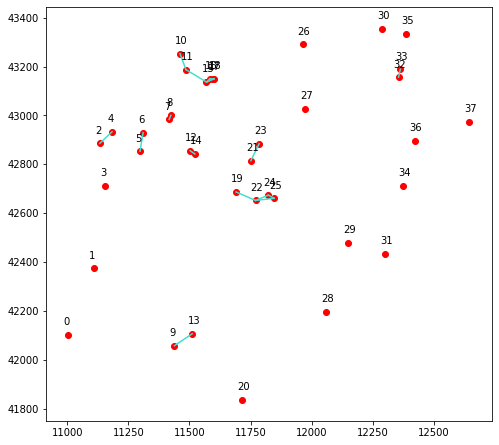

In [59]:
#Play around with the epsilon variable in the box above and see what happens
city_map.draw_map()

In [60]:
#That's a testbox, to see what initial path you can get
e = []
v = []
test = city_map.create_route()
for i in range(len(test)):
    e.append([test[i-1], test[i]])
    v.append(i)
city_map2 = graph(v,e)

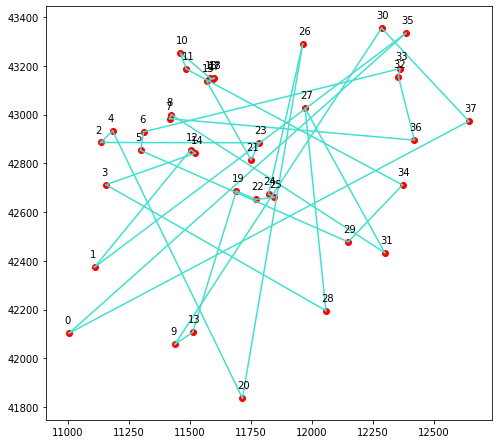

In [61]:
#It looks like that
city_map2.draw_map()

In [62]:
#Now resolve the Path
e = []
v = []
test = resolve(test)
for i in range(len(city_list)):
    e.append([test[i-1], test[i]])
    v.append(i)
city_map2 = graph(v,e)

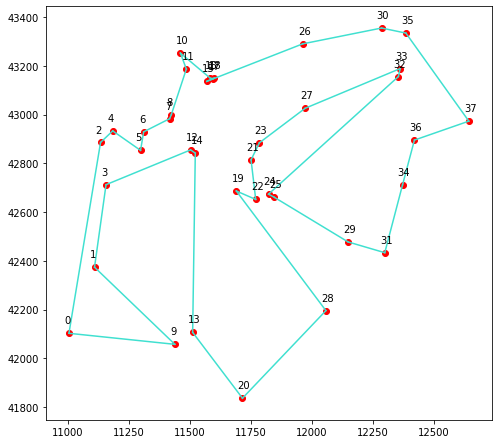

In [63]:
#Looks pretty good already ;)
city_map2.draw_map()

### This is the actual genetic Algorithm


In [64]:
#Make Initial guesses by using the graph defined by epsilon and resolving the route created by the graph class
population2 = [resolve(city_map.create_route()) for i in range(10)]

#mutation parameters, you can play around with that but you need to change the indices in the "MUTATION" part
weight = [1,1,1,1,2,2,3,5,10]
max_gen = 300
candidate = []
best_score = []
for t in range(max_gen):
    candidate = [population2[i] for i in range(len(population2))]
    for j in range(len(population2)):
        #CROSSOVER
        for k in range(5):
           
            ls = [population2[j][i] for i in range(len(population2[j]))]
            new = crossover(random.choice(population2), random.choice(population2),population2[j])
            candidate.append(new)
        #MUTATION
        for l in range(5):
            ls = [population2[j][i] for i in range(len(population2[j]))]
            p1 = mutate(random.choice(population2),weight[l])
            p2 = mutate(random.choice(population2),weight[l+4])
            new2 =crossover(p1, p2,population2[j])
            candidate.append(p1)
            candidate.append(p2)
            candidate.append(new2)
            
    score = np.array([fitness(candidate[i]) for i in range(len(candidate))])
    population2 = [candidate[i] for i in score.argsort()[:int(10*(np.log(1+t)+1))]]
    for i in range(3):
        population2.append(resolve(city_map.create_route()))
    best_score.append(score[score.argsort()[0]])
    
    #Here some output, to make sure the code is actually doing something and your notebook didn't die already
    if t%1 == 0:
        #population2 = [resolve(population2[i]) for i in range(len(population2))]
        print(t, best_score[t], len(population2))
        
    #Resolve the whole population after 50 generations
    #This is a compromise between best results (always resolving) and decent runtime
    if t%50 == 0:
        population2 = [resolve(population2[i], 50) for i in range(len(population2))]
    
population2 = [resolve(population2[i], 50) for i in range(len(population2))]
print(population2[0], fitness(population2[0]))

0 8719.827520800205 13
1 8711.776160958225 19
2 8711.776160958225 23
3 8574.907401899905 26
4 8574.907401899905 29
5 8453.244239689999 30
6 8420.237298795102 32
7 8234.972514097868 33
8 8146.30728004405 34
9 8146.30728004405 36
10 8146.30728004405 36
11 8014.262084787016 37
12 7879.440657108343 38
13 7879.440657108343 39
14 7769.483919478128 40
15 7705.581977640857 40
16 7705.581977640857 41
17 7466.724490985314 41
18 7403.433902187172 42
19 7371.825311430189 42
20 7371.825311430189 43
21 7371.825311430188 43
22 7335.257611264576 44
23 7335.257611264576 44
24 7265.259312432004 45
25 7265.259312432002 45
26 7265.259312432002 45
27 7265.259312432002 46
28 7197.0830215094065 46
29 7150.903202768657 47
30 7150.903202768657 47
31 7150.903202768655 47
32 7150.903202768655 47
33 7150.903202768654 48
34 7150.903202768654 48
35 7150.903202768654 48
36 7150.382780337046 49
37 7130.712010506841 49
38 7130.712010506841 49
39 7130.712010506841 49
40 7130.71201050684 50
41 7130.71201050684 50
42 713

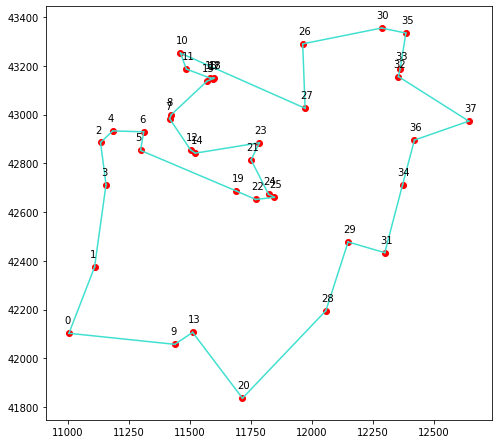

In [65]:
#Draw your best route
e = []
v = []
test = candidate[score.argsort()[0]]
for i in range(len(test)):
    e.append([test[i-1], test[i]])
    v.append(i)
city_map_2 = graph(v,e)
city_map_2.draw_map()

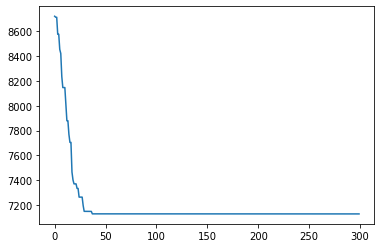

In [66]:
#And the fitness graph
plt.plot(best_score)